### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

# Chapter 03: New dataset based on US8K - US8K_AV

ASSUMPTION: run for dataset US8k:

* *01_Feature_extraction_exploration.ipynb*
* *02_PreProcessing_and_ML_modeling.ipynb* 

***

## Loading the dataset


In [1]:
import warnings
import mimetypes
import os
import random
import pickle
import librosa
import librosa.display

import pandas          as pd
import numpy           as np
import seaborn         as sns
import IPython.display as ipd

from matplotlib  import pyplot as plt


# Solution to play .ogg files in the IPython 
# https://stackoverflow.com/questions/39077987/ipython-display-audio-cannot-correctly-handle-ogg-file-type

SEED = 1000

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

In [2]:
# Global variables

current_path = os.getcwd()

# Values for feature extraction
threshold   = 60
frames      = 44
time_length = 4
SR          = 22050

# For the picture names
pic_first_name = '03_New_dataset_US8K_AV_'

dict_list    = []
path         = os.path.join(current_path, "_dataset", "US8K")
path_US8K_AV = os.path.join(current_path, "_dataset", "US8K_AV")
path_models  = os.path.join(current_path, "US8K_AV_saved_models")
path_pic     = os.path.join(current_path, "US8K_AV_results")


# Check if the folder exists, if not, create it
if not os.path.exists(path_US8K_AV):
    os.makedirs(path_US8K_AV)
    
# Check if the folder exists, if not, create it
if not os.path.exists(path_models):
    os.makedirs(path_models)

# Check if the folder exists, if not, create it
if not os.path.exists(path_pic):
    os.makedirs(path_pic)

subfolders  = next(os.walk(path))[1]
nom_dataset = 'US8K_AV' 
csv_file    = 'US8K.csv'
csv_new     = 'US8K_AV_no_silence.csv'
fold        = '1'

pkl_features          = 'US8K_AV_features_original.pkl'
pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large

In [3]:
# Export the dataframe as CSV file
def exportCSV(path: str, db):

    os.chdir(path)
    db.to_csv(csv_new)
    print("\nCSV exported.\nCheck the folder", path)

In [4]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [5]:
from MT_loadDataset import loadDataset

In [6]:
loader = loadDataset(path)
db     = loader.db_B

print("\nClasses:\n--------------------")
print(db["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(db["File_name"])))
print("Total number of AUDIO files...........: ", len(db))
db


CSV exported.
Check the folder :  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K

Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Total number of unique files..........:  8732
Total number of AUDIO files...........:  8732


,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


In [7]:
for col in db.columns:
    print(col)

Fold
Folder_name
Class_OHEV
Class_categorical
File_name
Path
classID
fsID
start
end
salience


In [8]:
def check_db(db: pd.DataFrame):
    
    numeric_cols = db.select_dtypes(include=['int64', 'float64'])

    # If there are no numeric columns, this will print an empty DataFrame
    print(numeric_cols)

    # If you want to check if there are any numeric columns
    if numeric_cols.empty:
        print("No int64 or float64 columns found in the DataFrame.")
    else:
        print("DataFrame contains int64 or float64 columns.")

In [9]:
check_db(db)

      Fold  classID    fsID       start         end  salience
0        5        3  100032    0.000000    0.317551         1
1        5        2  100263   58.500000   62.500000         1
2        5        2  100263   60.500000   64.500000         1
3        5        2  100263   63.000000   67.000000         1
4        5        2  100263   68.500000   72.500000         1
...    ...      ...     ...         ...         ...       ...
8727     7        1   99812  159.522205  163.522205         2
8728     7        1   99812  181.142431  183.284976         2
8729     7        1   99812  242.691902  246.197885         2
8730     7        1   99812  253.209850  255.741948         2
8731     7        1   99812  332.289233  334.821332         2

[8732 rows x 6 columns]
DataFrame contains int64 or float64 columns.


In [10]:
path, subfolders

('C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master\\_dataset\\US8K',
 ['fold1',
  'fold10',
  'fold2',
  'fold3',
  'fold4',
  'fold5',
  'fold6',
  'fold7',
  'fold8',
  'fold9'])

## Contruction of the new dataset - US8K_AV

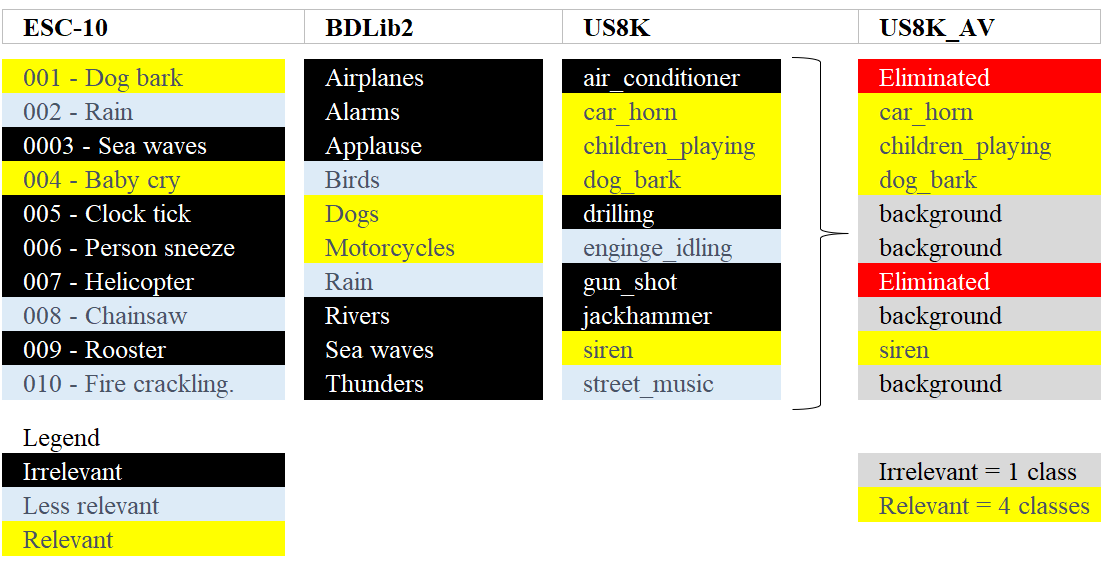

Class

* air_conditioner     1000
* gun_shot             374
* Total number of unique sound files.........:  8732
* Total number of WAV files..................:  8732

In [11]:
8732-1000-374

7358

In [12]:
db_new = db[~db['Class_categorical'].isin(['gun_shot', 'air_conditioner'])]
db_new

,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


In [13]:
print(db_new["Class_categorical"].value_counts())
print("\nTotal number of unique sound files.........: ", len(np.unique(db_new["File_name"])))

Class_categorical
dog_bark            1000
children_playing    1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique sound files.........:  7358


In [14]:
classes_to_remove = ['drilling', 'jackhammer', 'street_music', 'engine_idling']

# Iterate over the classes and remove 500 random samples from each class
for class_name in classes_to_remove:
    class_data     = db_new[db_new['Class_categorical'] == class_name]
    random_samples = class_data.sample(n = 750, random_state = SEED) 
    db_new         = db_new.drop(random_samples.index)

In [15]:
print(db_new["Class_categorical"].value_counts())
print("\nTotal number of unique sound files.........: ", len(np.unique(db_new["File_name"])))

Class_categorical
dog_bark            1000
children_playing    1000
siren                929
car_horn             429
street_music         250
engine_idling        250
jackhammer           250
drilling             250
Name: count, dtype: int64

Total number of unique sound files.........:  4358


In [16]:
class_data

,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
122,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,0.000000,4.000000,1
123,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,0.500000,4.500000,1
124,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,5.000000,9.000000,1
125,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,5.500000,9.500000,1
126,10,fold10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,102857,6.000000,10.000000,1
...,...,...,...,...,...,...,...,...,...
8532,2,fold2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,94710,0.500000,4.500000,1
8533,2,fold2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,94710,1.000000,5.000000,1
8534,2,fold2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,94710,1.500000,5.500000,1
8535,2,fold2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",engine_idling,...,94710,23.239672,25.325283,1


In [17]:
class_mapping = {'drilling': 'background',
                 'jackhammer': 'background',
                 'engine_idling': 'background',
                 'street_music': 'background'}

# Rename the classes using the mapping dictionary
db_new['Class_categorical'] = db_new['Class_categorical'].replace(class_mapping)

In [18]:
print(db_new["Class_categorical"].value_counts())
print("\nTotal number of unique sound files.........: ", len(np.unique(db_new["File_name"])))

Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique sound files.........:  4358


In [19]:
exportCSV(path_US8K_AV, db_new)


CSV exported.
Check the folder C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV


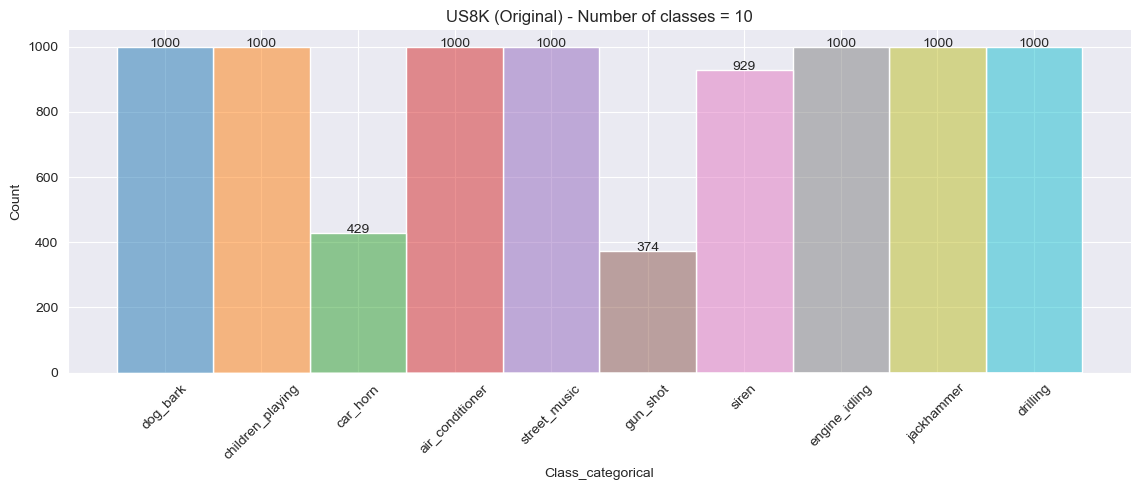

In [20]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K (Original) - Number of classes = ' + str(len(pd.Series(db['Class_categorical']).unique()))
g = sns.displot(db,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

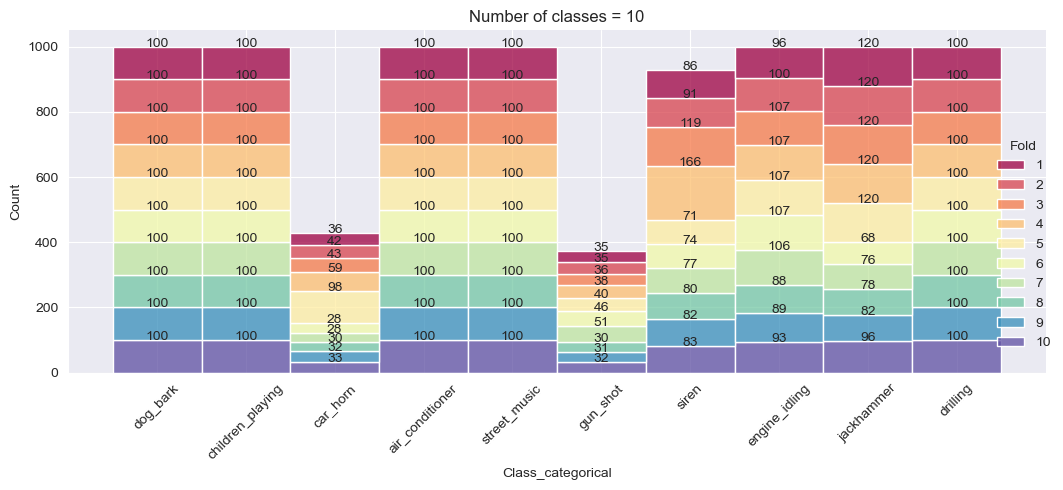

In [21]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'Number of classes = ' + str(len(pd.Series(db['Class_categorical']).unique()))
g = sns.displot(db, x='Class_categorical', hue='Fold',height = 5, aspect = 2, multiple='stack', palette='Spectral').set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = int(p.get_height())
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
#g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

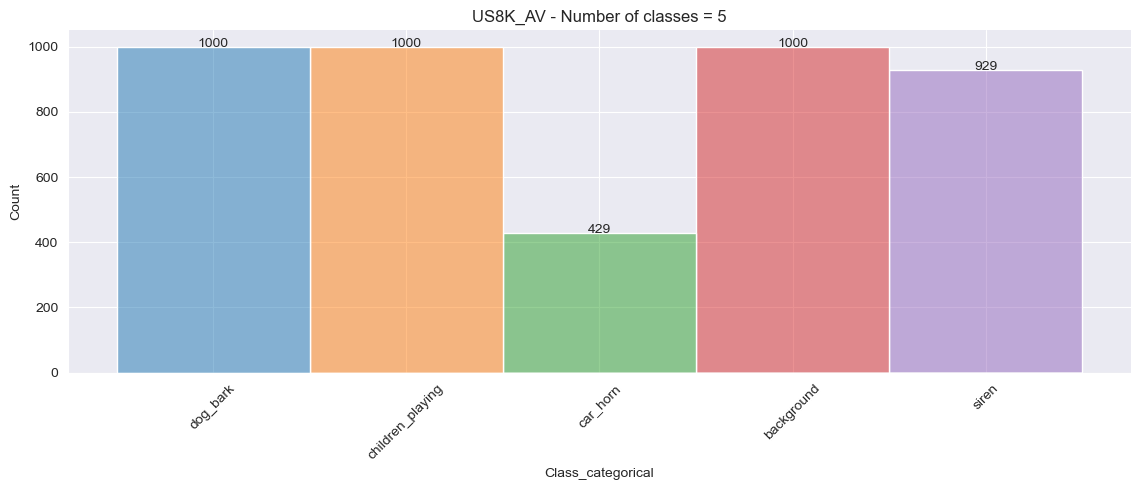

In [22]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K_AV - Number of classes = ' + str(len(pd.Series(db_new['Class_categorical']).unique()))
g = sns.displot(db_new,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

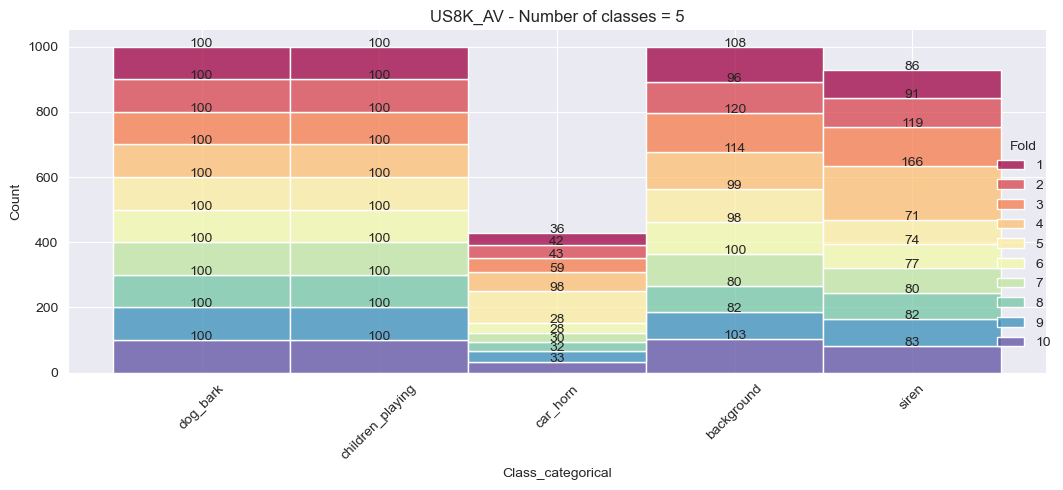

In [23]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K_AV - Number of classes = ' + str(len(pd.Series(db_new['Class_categorical']).unique()))
g = sns.displot(db_new, x='Class_categorical', hue='Fold', height = 5, aspect = 2, multiple='stack', palette='Spectral').set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = int(p.get_height())
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
#g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

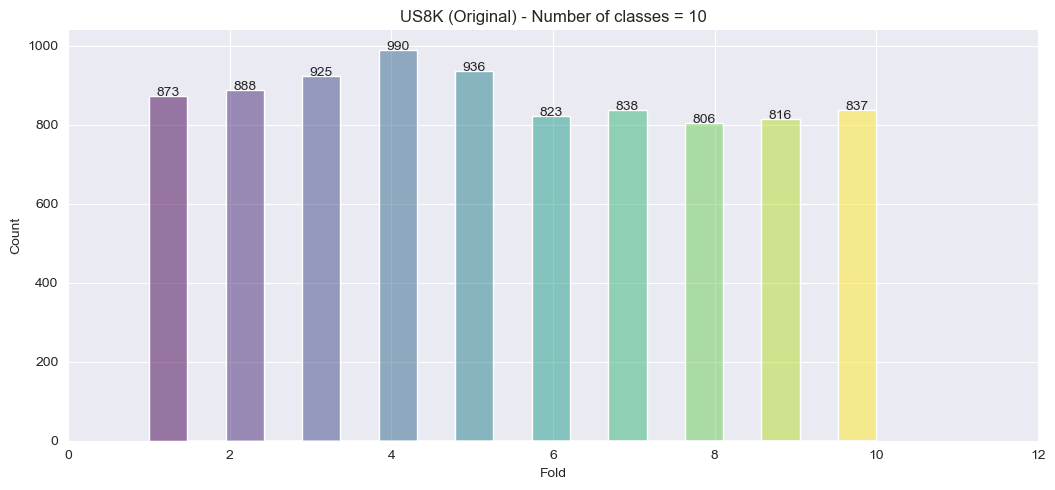

In [24]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K (Original) - Number of classes = ' + str(len(pd.Series(db['Class_categorical']).unique()))
db_sorted = db.sort_values('Fold')
g = sns.displot(db_sorted, x='Fold', hue='Fold', height = 5, aspect = 2, palette='viridis').set(title=gTitle)
g.set_xticklabels(rotation=0)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

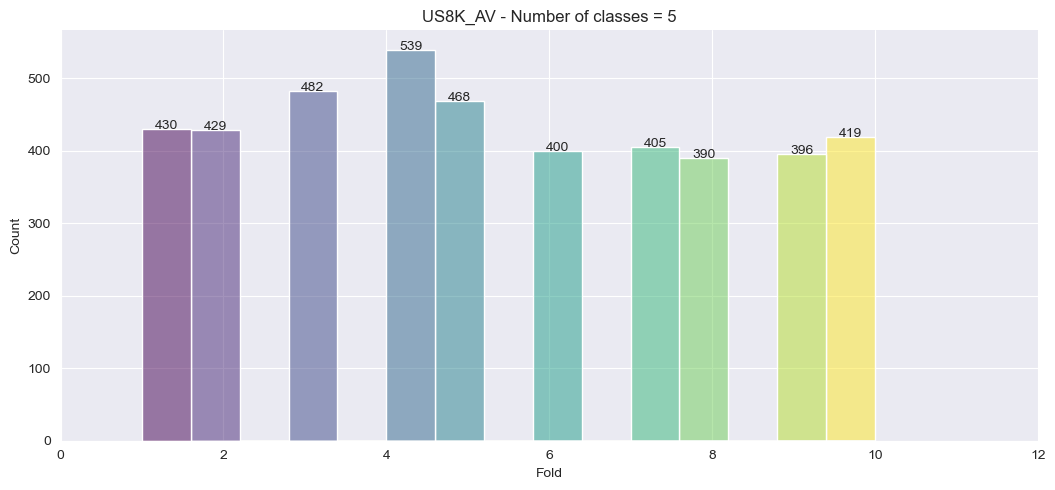

In [25]:
# Analysis of the class balancing

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

sns.set_style("darkgrid")
gTitle = 'US8K_AV - Number of classes = ' + str(len(pd.Series(db_new['Class_categorical']).unique()))
db_sorted = db_new.sort_values('Fold')
g = sns.displot(db_sorted, x='Fold', hue='Fold', height = 5, aspect = 2, palette='viridis').set(title=gTitle)
g.set_xticklabels(rotation=0)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = int(p.get_height())
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

In [26]:
for fold in range (1,11):
    print(len(db_new[db_new['Fold'] == fold]))

430
429
482
539
468
400
405
390
396
419


In [27]:
db_new.drop(columns = 'Class_OHEV', inplace = True)

In [28]:
def OHEV(db_B: pd.DataFrame):
    df_class  = db_B['Class_categorical']
    class_enc = np.array(pd.get_dummies(df_class, columns = [str], dtype=int))
    db_B.insert(loc = 2, column = 'Class_OHEV', value = class_enc.tolist())
    
    return db_B

In [29]:
# Update the OHEV with the new classes

db_new = OHEV(db_new)

In [30]:
db_new

,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


In [31]:
type(db_new['Class_OHEV'][0][0])

int

In [32]:
def exportCSV(db_B: pd.DataFrame):
    db_new.to_csv(os.path.join(path_US8K_AV, csv_new))
    print("\nCSV exported.\nCheck the folder : ", path_US8K_AV)

In [33]:
# Update the .CSV file with the new dataset

exportCSV(db_new)
del db_new


CSV exported.
Check the folder :  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV


In [37]:
# Testing loading the dataset metadata from the saved file

#loadDataset = loadDataset(path_US8K_AV)
#db_new      = loadDataset.db_B

db_new = pd.read_csv(os.path.join(path_US8K_AV, csv_new), dtype={'Fold': str})
db_new = db_new.drop('Unnamed: 0', axis=1)

print("\nClasses:\n--------------------")
print(db_new["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(db_new["File_name"])))
print("Total number of AUDIO files...........: ", len(db_new))
db_new


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4358
Total number of AUDIO files...........:  4358


,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
4353,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
4354,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
4355,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
4356,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


In [38]:
from MT_audioPP import audioPP
from MT_feature_extractor import feature_extractor

### Features ORIGINAL

* *aug*       = False
* *windowing* = False

In [38]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP_output = audioPP(db_new['Path'].values,
                         db_new['Class_categorical'].values, 
                         db_new['Class_OHEV'].values,
                         db_new['Fold'].values,
                         time_length = time_length,
                         threshold = threshold,
                         aug = False,
                         windowing = False,
                         frames = frames)
    
X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

100%|█████████████████████████████████████████████████████████████████████████████| 4358/4358 [00:34<00:00, 127.04it/s]
4358it [00:40, 107.96it/s]


Shape of the audio data..................: (4358, 88200)
Shape of the categorical label data......: (4358,)
Shape of the one hot encoder label data..: (4358,)
Shape of the fold data...................: (4358,)


In [39]:
# Parse every OHEV list as numpy array of integers (int32)
y_OHEV = [np.array(eval(s)) for s in y_OHEV]

In [40]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug[['Fold']] = db_aug[['Fold']].astype('str')
db_aug

,Audio,Class_categorical,Class_OHEV,Fold
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0]",5
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0]",5
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0]",5
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0]",5
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0]",5
...,...,...,...,...
4353,"[-0.00048753922, -0.0029013595, -0.0060868477, -0.0077148406, -0.008069417, -0.008534078, -0.008617738, -0.007554673...",car_horn,"[0, 1, 0, 0, 0]",7
4354,"[0.0018769287, 0.0028417986, 0.0028369268, 0.003081231, 0.0018484257, 0.0010519021, 0.00044334529, 0.0001646977, -3....",car_horn,"[0, 1, 0, 0, 0]",7
4355,"[-0.013202029, -0.020061549, -0.016201336, -0.014081302, -0.0110550765, -0.010160886, -0.012472121, -0.013130652, -0...",car_horn,"[0, 1, 0, 0, 0]",7
4356,"[0.0008518654, -0.003709917, -0.009393071, -0.009993944, -0.0063429633, -0.0011706308, 0.0025487966, 0.0038857076, 0...",car_horn,"[0, 1, 0, 0, 0]",7


In [41]:
dog_aug = db_aug[db_aug['Class_categorical'] == 'dog_bark']
dog_aug

,Audio,Class_categorical,Class_OHEV,Fold
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0]",5
14,"[0.00016530929, 8.096441e-05, 0.00010344596, 9.4123185e-05, -1.7766375e-05, 3.42282e-05, 0.00016252033, 0.0001439824...",dog_bark,"[0, 0, 0, 1, 0]",2
15,"[-0.0549016, -0.0030997097, 0.065438926, 0.066826925, 0.048625134, 0.00593441, 0.004272476, 0.033853546, 0.082438916...",dog_bark,"[0, 0, 0, 1, 0]",2
16,"[-0.0013541959, -0.0017534851, -0.00066222204, -0.00073858444, -0.0018295386, -0.005036477, -0.007678789, -0.0046168...",dog_bark,"[0, 0, 0, 1, 0]",2
17,"[-0.0021209174, -0.002075204, -0.00092535943, 0.00043941697, 0.004049227, 0.0050487723, 0.009374658, 0.009497762, 0....",dog_bark,"[0, 0, 0, 1, 0]",2
...,...,...,...,...
4295,"[0.12224058, 0.28320754, 0.36700976, 0.47181457, 0.57441556, 0.64737153, 0.6197049, 0.5389351, 0.48762226, 0.4169649...",dog_bark,"[0, 0, 0, 1, 0]",2
4296,"[-0.00022791978, -0.0012669582, -0.001694646, -0.0006031464, -0.0002898702, -0.00018023362, 0.00047345774, -0.000497...",dog_bark,"[0, 0, 0, 1, 0]",2
4312,"[-0.00047976524, -0.00039484072, -0.00035502762, -0.00034532882, -0.0002325438, -0.00013316981, -9.567477e-06, -8.69...",dog_bark,"[0, 0, 0, 1, 0]",6
4314,"[0.0028073888, 0.0015513706, -0.000205094, 0.0066186707, 0.005362046, 0.007070095, 0.009689612, 0.007504809, 0.01082...",dog_bark,"[0, 0, 0, 1, 0]",10


In [49]:
print(type(db_aug['Class_OHEV'][0]))
print(type(db_aug['Class_OHEV'][0][0]))

<class 'numpy.ndarray'>
<class 'numpy.int32'>


In [50]:
random_idx = random.choice(dog_aug.index.tolist())
random_sample = dog_aug['Audio'][random_idx]
print(f'Dataframe index....: {random_idx}')
print(f'Sample file name...: {random_sample}')

Dataframe index....: 2923
Sample file name...: [0.0252162  0.03630409 0.02977401 ... 0.00783411 0.00788143 0.00844951]


In [51]:
ipd.Audio(random_sample, rate = SR)

In [52]:
pkl_features

'US8K_AV_features_original.pkl'

In [53]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_original  = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_original.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_original.fillna(0, inplace=True)

    # Save the features to a pickle file (~1,514GB)
    DB_original.to_pickle(os.path.join(path_models, pkl_features))
    
    # Read the features from the pickle file
    DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

# If exist, read the pkl file with the features extracted
else:
    DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

100%|██████████████████████████████████████████████████████████████████████████████| 4358/4358 [52:22<00:00,  1.39it/s]


Columns with NaN values:
CHROMA_skew_1         True
CHROMA_kurtosis_1     True
CHROMA_skew_3         True
CHROMA_kurtosis_3     True
CHROMA_skew_4         True
CHROMA_kurtosis_4     True
CHROMA_skew_5         True
CHROMA_kurtosis_5     True
CHROMA_skew_6         True
CHROMA_kurtosis_6     True
CHROMA_skew_7         True
CHROMA_kurtosis_7     True
CHROMA_skew_8         True
CHROMA_kurtosis_8     True
CHROMA_skew_9         True
CHROMA_kurtosis_9     True
CHROMA_skew_10        True
CHROMA_kurtosis_10    True
CHROMA_skew_11        True
CHROMA_kurtosis_11    True
CHROMA_skew_12        True
CHROMA_kurtosis_12    True
dtype: bool


In [54]:
DB_ori_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024244,-0.049756,0.759231,-0.024962
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0]",5,...,0.018670,-0.018241,0.275013,-0.497943
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0]",5,...,0.018733,0.009139,-0.205466,-0.212879
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0]",5,...,0.027117,0.007208,-0.769827,0.623153
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0]",5,...,0.025776,0.050245,0.208739,-1.062755
...,...,...,...,...,...,...,...,...,...
4353,"[-0.00048753922, -0.0029013595, -0.0060868477, -0.0077148406, -0.008069417, -0.008534078, -0.008617738, -0.007554673...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.022642,0.008688,0.097807,-0.866208
4354,"[0.0018769287, 0.0028417986, 0.0028369268, 0.003081231, 0.0018484257, 0.0010519021, 0.00044334529, 0.0001646977, -3....",car_horn,"[0, 1, 0, 0, 0]",7,...,0.029405,0.020661,-0.220407,1.997790
4355,"[-0.013202029, -0.020061549, -0.016201336, -0.014081302, -0.0110550765, -0.010160886, -0.012472121, -0.013130652, -0...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.034195,-0.002075,0.725307,-0.462707
4356,"[0.0008518654, -0.003709917, -0.009393071, -0.009993944, -0.0063429633, -0.0011706308, 0.0025487966, 0.0038857076, 0...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.029228,-0.005832,-0.330073,-0.796058


In [55]:
print(type(DB_ori_from_pkl['Fold'][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [56]:
print(len(DB_ori_from_pkl))

4358


In [57]:
DB_ori_from_pkl.shape

(4358, 379)

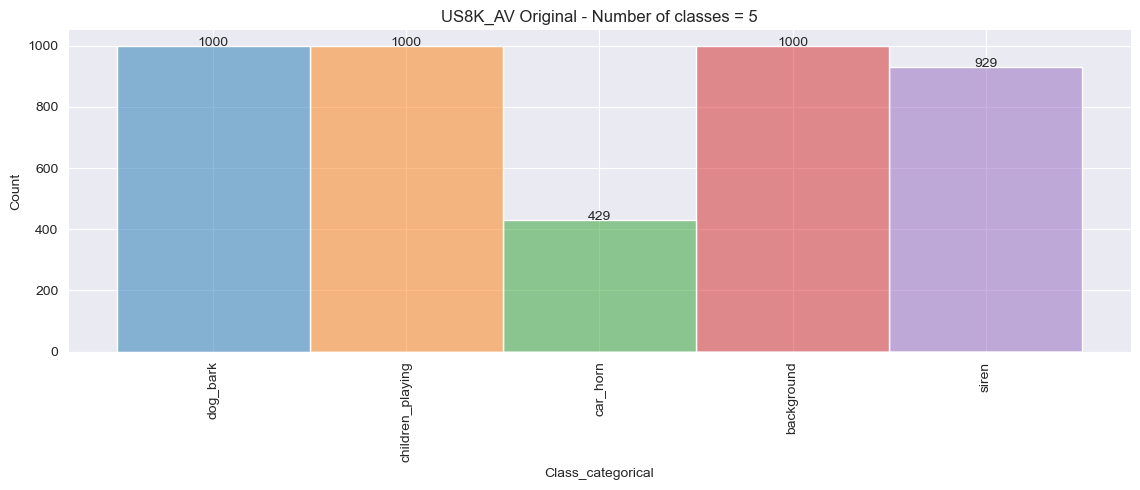

In [61]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Original - Number of classes = ' + str(len(pd.Series(DB_ori_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_ori_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

### Features AUGMENTED

* *aug*       = True
* *windowing* = False

Dataset will be 6x larger (original + time stretching .85 / 1.15, pitch shifting -4 / +4 semitons, and time shifting randomly)

ATTENTION: you may need to split this process in more than 2 steps due memory allocation constrains

In [60]:
for i in range(2):
    subset_db = db_new[int(i*len(db_new)/2):int((i+1)*len(db_new)/2)]

    audioPP_output = audioPP(subset_db['Path'].values,
                             subset_db['Class_categorical'].values, 
                             subset_db['Class_OHEV'].values,
                             subset_db['Fold'].values,
                             time_length = time_length,
                             threshold = threshold,
                             aug = True,
                             windowing = False,
                             frames = frames)

    X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

    # Delete the subsets to clear memory
    del subset_db 

    # Parse every OHEV list as numpy array of integers (int32)
    y_OHEV = [np.array(eval(s)) for s in y_OHEV]

    db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
    db_aug[['Fold']] = db_aug[['Fold']].astype('str')

    del X, y_string, y_OHEV, folds # Delete to clear memory

    # Save db_aug as a pickle file
    with open(os.path.join(path_models, f'db_aug_{i+1}.pkl'), 'wb') as f:
        pickle.dump(db_aug, f)

    del db_aug  # Delete db_aug to clear memory

# Read and join both db_aug_1 and db_aug_2 into db_aug
with open(os.path.join(path_models,'db_aug_1.pkl'), 'rb') as f:
    db_aug_1 = pickle.load(f)

with open(os.path.join(path_models,'db_aug_2.pkl'), 'rb') as f:
    db_aug_2 = pickle.load(f)

db_aug = pd.concat([db_aug_1, db_aug_2], ignore_index=True)

del db_aug_1, db_aug_2
os.remove(os.path.join(path_models,'db_aug_1.pkl'))
os.remove(os.path.join(path_models,'db_aug_2.pkl'))

100%|██████████████████████████████████████████████████████████████████████████████| 2179/2179 [06:58<00:00,  5.21it/s]
13074it [02:55, 74.52it/s] 


Shape of the audio data..................: (13074, 88200)
Shape of the categorical label data......: (13074,)
Shape of the one hot encoder label data..: (13074,)
Shape of the fold data...................: (13074,)


100%|██████████████████████████████████████████████████████████████████████████████| 2179/2179 [12:12<00:00,  2.98it/s]
13074it [03:41, 58.94it/s] 


Shape of the audio data..................: (13074, 88200)
Shape of the categorical label data......: (13074,)
Shape of the one hot encoder label data..: (13074,)
Shape of the fold data...................: (13074,)


In [62]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [63]:
db_aug['Audio'][random_idx*6] # 6x due augmentation to get the same sample as the original

array([0.0252162 , 0.03630409, 0.02977401, ..., 0.00783411, 0.00788143,
       0.00844951], dtype=float32)

In [64]:
ipd.Audio(random_sample, rate = SR)

In [65]:
ipd.Audio(db_aug.at[random_idx*6 + 1, 'Audio'], rate = SR) # First augmentation of the original audio

In [66]:
librosa.get_duration(y = db_aug['Audio'][random_idx*6 + 1]) # 6x due augmentation to get the same sample as the original

4.0

In [67]:
pkl_aug_features

'US8K_AV_features_augmented_no_windowing.pkl'

In [68]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_aug_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_augmented = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_augmented.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_augmented.fillna(0, inplace=True)
    
    # Save the features to a pickle file (~10,588GB)
    DB_augmented.to_pickle(os.path.join(path_models, pkl_aug_features))
    
    # Read the features from the pickle file
    DB_aug_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_features))

# If exist, read the pkl file with the features extracted
else:
    DB_aug_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_features))

100%|██████████████████████████████████████████████████████████████████████████| 26148/26148 [7:39:20<00:00,  1.05s/it]


Columns with NaN values:
CHROMA_skew_1         True
CHROMA_kurtosis_1     True
CHROMA_skew_2         True
CHROMA_kurtosis_2     True
CHROMA_skew_3         True
CHROMA_kurtosis_3     True
CHROMA_skew_4         True
CHROMA_kurtosis_4     True
CHROMA_skew_5         True
CHROMA_kurtosis_5     True
CHROMA_skew_6         True
CHROMA_kurtosis_6     True
CHROMA_skew_7         True
CHROMA_kurtosis_7     True
CHROMA_skew_8         True
CHROMA_kurtosis_8     True
CHROMA_skew_9         True
CHROMA_kurtosis_9     True
CHROMA_skew_10        True
CHROMA_kurtosis_10    True
CHROMA_skew_11        True
CHROMA_kurtosis_11    True
CHROMA_skew_12        True
CHROMA_kurtosis_12    True
dtype: bool


In [69]:
DB_aug_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024244,-0.049756,0.759231,-0.024962
1,"[0.0003421773763831555, 0.0007679484025333847, 0.0006172665123464571, -0.0009160229970455152, 0.0006729400722995924,...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024727,-0.021532,0.288063,-0.472065
2,"[-0.0035122973, -0.0050051752, -0.0045919046, -0.0048774146, -0.0037652655, -0.0022669514, -0.00015891435, 0.0014704...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.031054,-0.028243,0.298586,-0.490271
3,"[-0.003488453, -0.004396054, -0.0037757251, -0.0042094756, -0.0030081559, -0.0015460963, 0.00081547524, 0.0026281716...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.025748,-0.000898,-0.077263,-0.095841
4,"[-0.003237898, -0.0050192326, -0.0046117576, -0.004234772, -0.0019701908, 0.00027243508, 0.0026218973, 0.004221949, ...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.027486,0.031821,-0.303592,0.219901
...,...,...,...,...,...,...,...,...,...
26143,"[-0.004366717301309109, -0.00414634495973587, -0.006198013201355934, -0.005255931988358498, -0.0025103744119405746, ...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.041478,-0.027959,-0.522640,-0.821316
26144,"[0.013614702, 0.025402728, 0.023213908, 0.021975169, 0.016956959, 0.015239683, 0.010343045, 0.008701391, 0.006488053...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.035080,-0.011528,-0.423708,-0.874833
26145,"[0.013724111, 0.025209483, 0.02299475, 0.021716274, 0.016808376, 0.015125214, 0.010314408, 0.008703265, 0.006482009,...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.040739,-0.032216,-0.795570,-0.144473
26146,"[0.013087595, 0.025674945, 0.022199064, 0.01882483, 0.014130215, 0.0101510435, 0.0071426327, 0.007999478, 0.01828633...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.034881,-0.006539,0.611093,-0.761275


In [70]:
print(type(DB_aug_from_pkl['Fold'][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [71]:
print(len(DB_aug_from_pkl))

26148


In [72]:
DB_aug_from_pkl.shape

(26148, 379)

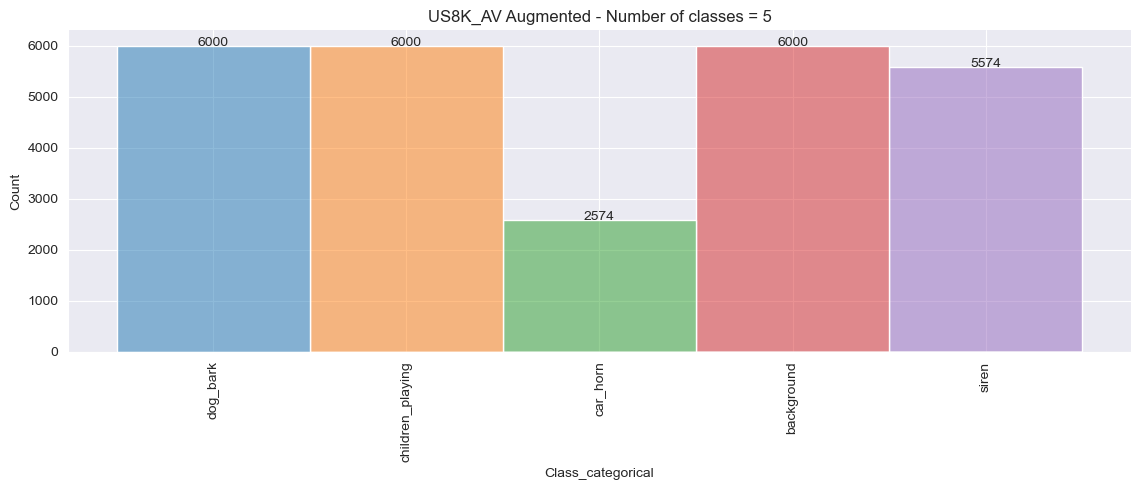

In [73]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Augmented - Number of classes = ' + str(len(pd.Series(DB_aug_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

### Features AUGMENTED and WINDOWED

* *aug*       = False
* *windowing* = True

Dataset will have 4,358 * 7 = 30,506 samples.

ATTENTION: you may need to split this process due memory allocation constrains

In [74]:
# Clear the memory
del db_aug, DB_ori_from_pkl, DB_aug_from_pkl

In [75]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP_output = audioPP(db_new['Path'].values,
                         db_new['Class_categorical'].values, 
                         db_new['Class_OHEV'].values,
                         db_new['Fold'].values,
                         time_length = time_length,
                         threshold = threshold,
                         aug = False,
                         windowing = True,
                         frames = frames)
    
X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

100%|██████████████████████████████████████████████████████████████████████████████| 4358/4358 [01:24<00:00, 51.64it/s]
4358it [02:36, 27.79it/s]
100%|███████████████████████████████████████████████████████████████████████████| 4358/4358 [00:00<00:00, 29543.32it/s]


Shape of the audio data..................: (30506, 22016)
Shape of the categorical label data......: (30506,)
Shape of the one hot encoder label data..: (30506,)
Shape of the fold data...................: (30506,)


In [76]:
# Parse every OHEV list as numpy array of integers (int32)
y_OHEV = [np.array(eval(s)) for s in y_OHEV]

In [77]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug[['Fold']] = db_aug[['Fold']].astype('str')

In [78]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [79]:
ipd.Audio(random_sample, rate = SR)

In [80]:
random_idx

2923

In [81]:
print(librosa.get_duration(y = db_aug.at[random_idx * 1 * 7, 'Audio']))
ipd.Audio(db_aug.at[random_idx * 1 * 7, 'Audio'], rate = SR)

0.9984580498866213


In [82]:
pkl_aug_wind_features

'US8K_AV_features_windowed.pkl'

In [83]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_aug_wind_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_aug_wind  = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_aug_wind.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_aug_wind.fillna(0, inplace=True)
    
    # Save the features to a pickle file (~2,714GB)
    DB_aug_wind.to_pickle(os.path.join(path_models, pkl_aug_wind_features)) 
    
    # Read the features from the pickle file
    DB_aug_wind_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))

# If exist, read the pkl file with the features extracted
else:
    DB_aug_wind_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))

100%|██████████████████████████████████████████████████████████████████████████| 30506/30506 [4:26:42<00:00,  1.91it/s]


Columns with NaN values:
CHROMA_skew_1         True
CHROMA_kurtosis_1     True
CHROMA_skew_2         True
CHROMA_kurtosis_2     True
CHROMA_skew_3         True
CHROMA_kurtosis_3     True
CHROMA_skew_4         True
CHROMA_kurtosis_4     True
CHROMA_skew_5         True
CHROMA_kurtosis_5     True
CHROMA_skew_6         True
CHROMA_kurtosis_6     True
CHROMA_skew_7         True
CHROMA_kurtosis_7     True
CHROMA_skew_8         True
CHROMA_kurtosis_8     True
CHROMA_skew_9         True
CHROMA_kurtosis_9     True
CHROMA_skew_10        True
CHROMA_kurtosis_10    True
CHROMA_skew_11        True
CHROMA_kurtosis_11    True
CHROMA_skew_12        True
CHROMA_kurtosis_12    True
dtype: bool


In [84]:
DB_aug_wind_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.025644,-0.046785,0.461191,-0.338882
1,"[-0.015428771, -0.0064468235, -0.002025701, -0.009768408, -0.020482529, -0.03246226, -0.046539657, -0.050950672, -0....",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.026433,-0.030688,0.414979,-0.840459
2,"[-0.17165461, -0.1961453, -0.2095497, -0.116395764, 0.02499168, 0.15181583, 0.2456393, 0.24304995, 0.1697193, 0.0706...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.023640,-0.045384,0.629947,0.096665
3,"[-0.004147315, -0.014180049, -0.016550057, -0.017083425, -0.010863152, -0.0018686495, 0.006234308, 0.00725661, 0.005...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024617,-0.025407,0.554764,-0.364067
4,"[-0.047271818, -0.08598116, -0.08329079, -0.15244874, -0.21367016, -0.26584676, -0.19677721, -0.17195633, -0.0841544...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...
30501,"[-0.024376377, -0.010054192, 0.0009410139, 0.005863713, -0.0005189497, -0.0021953415, 0.0013682423, -0.0043018945, -...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.033488,-0.069738,0.175013,-0.974133
30502,"[0.0066777063, 0.008175363, 0.006157635, 0.0026387093, 0.00059039844, 0.0030925209, 0.0033645788, 0.0056151543, 0.00...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.021007,-0.018432,-0.690702,-0.099409
30503,"[-0.0020232266, 0.001032982, 0.0023606261, 0.0017964527, 0.0009908059, -0.0011728329, -0.003362489, -0.0054453667, -...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.021124,-0.016391,-0.028383,-1.071243
30504,"[-0.0015619812, 0.0005301243, 0.0032789772, 0.002725502, 0.0023546133, -0.0019822496, -0.002666029, -0.004454969, -0...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.027106,-0.017513,-0.121982,-0.606880


In [85]:
print(type(DB_aug_wind_from_pkl['Fold'][0]))
print(type(DB_aug_wind_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_wind_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [86]:
print(len(DB_aug_wind_from_pkl))

30506


In [87]:
DB_aug_wind_from_pkl.shape

(30506, 379)

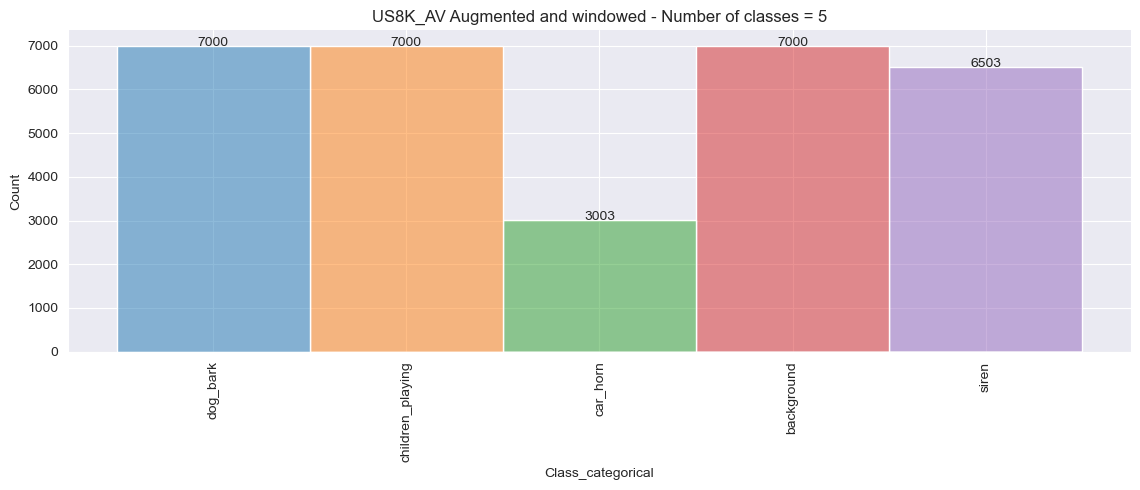

In [88]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Augmented and windowed - Number of classes = ' + str(len(pd.Series(DB_aug_wind_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_wind_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

# End of notebook